<a href="https://colab.research.google.com/gist/SharanSMenon/887afed7d8538d35d1add819d129114a/dcgan-pytorch-mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchsummary import summary

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
from torch import nn, optim
from torch.nn import functional as F

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def conv(in_c, out_c, ks=4, stride=2, padding=1, bn = True, out_layer=False):
    layers = [nn.Conv2d(in_c, out_c, kernel_size=ks, stride=stride, padding=padding, bias=False)]
    if bn: layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.Sigmoid() if out_layer else nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

In [ ]:
D = nn.Sequential(
    conv(1, 32, bn=False),
    conv(32, 64),
    conv(64, 128, ks=3),
    conv(128, 1, out_layer=True, bn=False, padding=0),
)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.layers = nn.Sequential(*[
                                 self.conv_block(100, 128, padding=0),
                                 self.conv_block(128, 64, stride=2, ks=3),
                                 self.conv_block(64, 32, stride=2),
                                 self.conv_block(32, 1, stride=2, bn=False, out_layer=True)
    ])
  
  @staticmethod
  def conv_block(in_c, out_c, out_layer = False, ks=4, stride=1, padding=1, bias=False, bn=True):
    l = [nn.ConvTranspose2d(in_c, out_c, ks, stride=stride, padding=padding, bias=bias)]
    if bn: l.append(nn.BatchNorm2d(out_c))
    if out_layer: l.append(nn.Tanh())
    else: l.append(nn.ReLU(True))
    return nn.Sequential(*l)

  
  def forward(self, x):
    return self.layers(x)


In [ ]:
G = Generator()

In [ ]:
D

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Sigmoid()
  )
)

In [ ]:
G

Generator(
  (layers): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Tanh()
    )
  )
)

In [ ]:
rand_noise = torch.rand((64, 100, 1, 1))
G.apply(weights_init)
D.apply(weights_init)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Sigmoid()
  )
)

In [ ]:
criterion = nn.BCELoss()

In [ ]:
optim_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
D = D.cuda()
G = G.cuda()
criterion = criterion.cuda()

In [ ]:
for epoch in range(1, EPOCHS + 1):
    loss_d = 0.0
    loss_g = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images = images.cuda() # if cuda
        fake_labels = torch.full((images.size(0),), FAKE_LABEL).cuda()
        real_labels = torch.full((images.size(0),), REAL_LABEL).cuda()

        ### Training Discriminator ###
        ### Maximize log(D(x)) + log(1 - D(G(z))) ###
        D.zero_grad()

        d_real = D(images).view(-1)
        d_loss_real = criterion(d_real, real_labels)
        d_loss_real.backward()

        noise = torch.randn(images.size(0), 100, 1, 1).cuda()
        fake_images = G(noise)

        d_fake = D(fake_images.detach()).view(-1)
        d_loss_fake = criterion(d_fake, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optim_D.step()

        ### Training Generator ###
        ### Maximize log(D(G(z))) ###
        G.zero_grad()
        d_fake = D(fake_images).view(-1)
        g_loss = criterion(d_fake, real_labels)
        g_loss.backward()
        optim_G.step()

        if i % 100 == 0:
          print('Epoch [{}/{}], Batch [{}], Loss_D: {:.4f}, Loss_G: {:.4f}'.format(epoch, EPOCHS, i, d_loss, g_loss))
    

Epoch [1/10], Batch [0], Loss_D: 1.3001, Loss_G: 0.9725
Epoch [1/10], Batch [100], Loss_D: 0.1149, Loss_G: 3.2734
Epoch [1/10], Batch [200], Loss_D: 0.2295, Loss_G: 2.8770
Epoch [1/10], Batch [300], Loss_D: 0.1363, Loss_G: 3.2608
Epoch [1/10], Batch [400], Loss_D: 0.3577, Loss_G: 2.9370
Epoch [2/10], Batch [0], Loss_D: 0.1583, Loss_G: 3.3581
Epoch [2/10], Batch [100], Loss_D: 0.1059, Loss_G: 3.2018
Epoch [2/10], Batch [200], Loss_D: 0.2606, Loss_G: 1.9497
Epoch [2/10], Batch [300], Loss_D: 0.8414, Loss_G: 6.3635
Epoch [2/10], Batch [400], Loss_D: 4.7866, Loss_G: 2.7104
Epoch [3/10], Batch [0], Loss_D: 0.2102, Loss_G: 3.2500
Epoch [3/10], Batch [100], Loss_D: 0.2284, Loss_G: 2.2332
Epoch [3/10], Batch [200], Loss_D: 0.3167, Loss_G: 3.3116
Epoch [3/10], Batch [300], Loss_D: 0.6720, Loss_G: 1.5293
Epoch [3/10], Batch [400], Loss_D: 0.3406, Loss_G: 2.7290
Epoch [4/10], Batch [0], Loss_D: 0.3795, Loss_G: 1.7760
Epoch [4/10], Batch [100], Loss_D: 0.6796, Loss_G: 1.3558
Epoch [4/10], Batch [2

In [ ]:
import numpy as np
import torchvision.utils as vutils

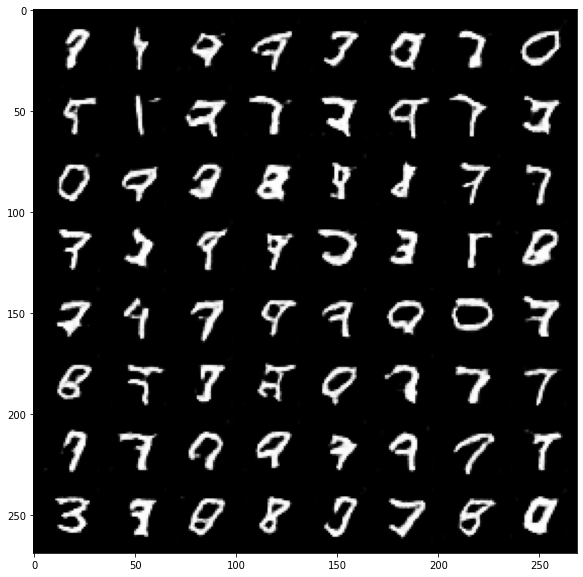

In [ ]:
fig = plt.figure(figsize=(10, 10))
rand_noise = torch.rand((64, 100, 1, 1))
out = vutils.make_grid(G(rand_noise.cuda()).cpu().detach(), padding=5, normalize=True)
plt.imshow(np.transpose(out.numpy(), (1, 2, 0)), cmap='gray')